In [1]:
import sys
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from hessian_eigenthings import compute_hessian_eigenthings
plt.style.use("dark_background")
%matplotlib inline

In [2]:
sys.path.append("../../src")
from models import MLP
from data import gen_rnd_ds
from losses import LinearClassification, SquaredClassification
from block_analysis import *
from derivation import get_hessian_grad_block, block_norm

## Params

In [6]:
mode = "linear"
bias = False
nlayer = 2
inp_dim = 10 
out_dim = 10
hid_dim = 10
nsamp = 5000
Neigen = 50
device = 0

### Understood

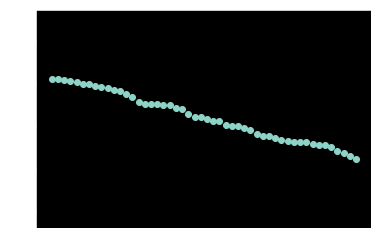

In [11]:
inp_mean = 0
inp_var = 1
ds = gen_rnd_ds(inp_dim, inp_mean, inp_var, 
                out_dim, nsamp, device)
loss_fn = SquaredClassification(out_dim)
model = nn.Linear(inp_dim, out_dim, bias=False).cuda()

eigenvals, eigenvecs = compute_hessian_eigenthings(model, ds,
                                                  loss_fn, Neigen)

plt.scatter(torch.arange(len(eigenvals)), eigenvals)

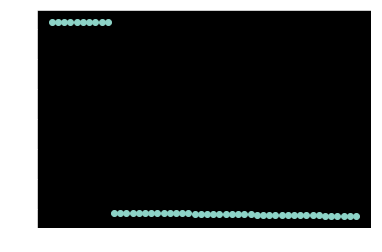

In [9]:
# Non-centered input create out_dim outlier eigen-values
inp_mean = 1
inp_var = 1

ds = gen_rnd_ds(inp_dim, inp_mean, inp_var, 
                out_dim, nsamp, device)
loss_fn = SquaredClassification(out_dim)
model = nn.Linear(inp_dim, out_dim, bias=False).cuda()

eigenvals, eigenvecs = compute_hessian_eigenthings(model, ds,
                                                  loss_fn, Neigen)

plt.scatter(torch.arange(len(eigenvals)), eigenvals)

## Not Understood

### Two layers - Squared loss

The spectrum of centered inputs show some weird features

The spectrum of non-centered inputs:
- No longer shows a clean separation of the outliers
- also has a weird, though less obvious, breaking point

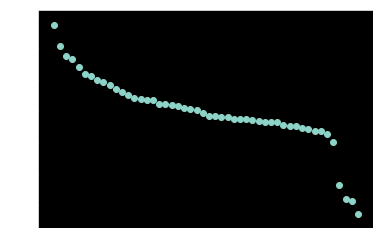

In [13]:
inp_mean = 0
inp_var = 1

ds = gen_rnd_ds(inp_dim, inp_mean, inp_var, 
                out_dim, nsamp, device)
loss_fn = SquaredClassification(out_dim)
model = nn.Sequential(*[
    nn.Linear(inp_dim, hid_dim, bias=False).cuda(),
    nn.Linear(hid_dim, out_dim, bias=False).cuda()
])

eigenvals, eigenvecs = compute_hessian_eigenthings(model, ds,
                                                  loss_fn, Neigen)

plt.scatter(torch.arange(len(eigenvals)), eigenvals)

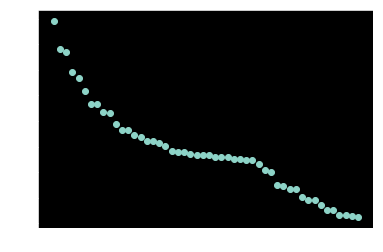

In [12]:
inp_mean = 1
inp_var = 1

ds = gen_rnd_ds(inp_dim, inp_mean, inp_var, 
                out_dim, nsamp, device)
loss_fn = SquaredClassification(out_dim)
model = nn.Sequential(*[
    nn.Linear(inp_dim, hid_dim, bias=False).cuda(),
    nn.Linear(hid_dim, out_dim, bias=False).cuda()
])

eigenvals, eigenvecs = compute_hessian_eigenthings(model, ds,
                                                  loss_fn, Neigen)

plt.scatter(torch.arange(len(eigenvals)), eigenvals)

### Two layers, linear loss

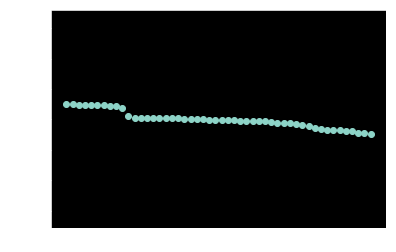

In [15]:
inp_mean = 0
inp_var = 1

ds = gen_rnd_ds(inp_dim, inp_mean, inp_var, 
                out_dim, nsamp, device)
loss_fn = LinearClassification(out_dim)
model = nn.Sequential(*[
    nn.Linear(inp_dim, hid_dim, bias=False).cuda(),
    nn.Linear(hid_dim, out_dim, bias=False).cuda()
])

eigenvals, eigenvecs = compute_hessian_eigenthings(model, ds,
                                                  loss_fn, Neigen)
plt.scatter(torch.arange(len(eigenvals)), eigenvals)

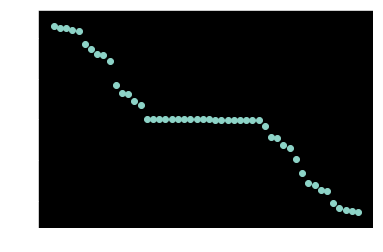

In [14]:
inp_mean = 1
inp_var = 1

ds = gen_rnd_ds(inp_dim, inp_mean, inp_var, 
                out_dim, nsamp, device)
loss_fn = LinearClassification(out_dim)
model = nn.Sequential(*[
    nn.Linear(inp_dim, hid_dim, bias=False).cuda(),
    nn.Linear(hid_dim, out_dim, bias=False).cuda()
])

eigenvals, eigenvecs = compute_hessian_eigenthings(model, ds,
                                                  loss_fn, Neigen)
plt.scatter(torch.arange(len(eigenvals)), eigenvals)

### Legacy: David Page's eigen tools adaptation

In [ ]:
import scipy.sparse.linalg
from itertools import count

loss_grad = lambda model, x: to_vec(torch.autograd.grad( loss_fn(model(x[0]),x[1]),
                                                            list(model.parameters()), 
                                                            create_graph=True
                                                          )
                                      )

to_vec = lambda list_of_tensors: torch.cat([x.reshape(-1) for x in list_of_tensors])

def flatten(x):
    return x.view(x.size(0), x.size(1))

def to_numpy(x):
    if isinstance(x, torch.Tensor):
        return x.detach().cpu().numpy()  
    return x

def compute_grad(model, batches, outputs, vec=None):
    return sum(to_vec(torch.autograd.grad(outputs(model, batch), list(model.parameters()), grad_outputs=vec, only_inputs=True)).to(dtype=torch.float)
        for batch in batches)/len(batches) #i believe sum(generator)/len is memory efficient but i haven't checked...


class HvOperator(scipy.sparse.linalg.LinearOperator):
    def __init__(self, model, batches, projection=None):
        self.model, self.batches, self.projection = model, batches, projection
        params = list(model.parameters())
        size = int(sum(x.numel() for x in params))
        self.shape = (size, size)
        self.dtype, self.torch_dtype = np.dtype('float32'), params[0].dtype
        #self.iteration, self.table, self.timer = count(1), Table(report_every=10), Timer()

    def _matvec(self, v):
        v = torch.tensor(v, dtype=self.torch_dtype, device=device)
        Hv = to_numpy(compute_grad(self.model, self.batches, loss_grad, v))
        #self.table.append({'iteration': next(self.iteration), 'time': self.timer(), 'total time': self.timer.total_time})
        return self.projection(Hv) if self.projection else Hv

def compute_top_k_eigens(op, k, tol=1e-4):
    eigenvals, eigenvecs = scipy.sparse.linalg.eigsh(A=op, k=k, tol=tol, return_eigenvectors=True)
    return eigenvals[-1::-1], eigenvecs.T[-1::-1]

Neigen = 5
model, ds, loss_fn = get_model_ds_loss()
model = nn.Linear(inp_dim, out_dim, bias=False).cuda()

op = HvOperator(model, ds)
eigenvals, eigenvecs = compute_top_k_eigens(op, k=Neigen)
plt.scatter(torch.arange(len(eigenvals)), eigenvals)